# Week 6

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
GPU count: 1
Device 0: NVIDIA GeForce RTX 3080 Ti


## Lecture 11 - Convolutional Neural Networks

In this notebook, we move beyond **Multi-Layer Perceptrons (MLPs)** and train our first **Convolutional Neural Network (CNN)**. Unlike MLPs, CNNs take advantage of **spatial structure** in images by using convolutional layers.  
This allows them to:
- Share parameters across different parts of the image (translation invariance).
- Learn **local patterns** first, then combine them into **hierarchical features**.
- Achieve much better performance on image data compared to dense layers alone.

### CIFAR-10 Experiment

We use a **LeNet-style** architecture — one of the earliest successful CNNs — adapted for the CIFAR-10 dataset.

Our network follows a modified **LeNet-5** structure:
1. **Conv Layer (3→6)** → ReLU → Pooling (MaxPool in our case).
2. **Conv Layer (6→16)** → ReLU → Pooling.
3. **Flatten** → Fully Connected (120) → ReLU.
4. Fully Connected (84) → ReLU.
5. Fully Connected (10) → Output logits for CIFAR-10 classes.

We use **He initialization** for all convolutional and fully connected layers to improve convergence with ReLU activations.

#### Training Setup
- **Dataset:** CIFAR-10, split into train/validation/test sets.
- **Augmentation:** Random crop and horizontal flip for training images.
- **Normalization:** Per-channel mean/std for CIFAR-10.
- **Loss Function:** Cross-Entropy Loss with mild label smoothing (0.05) to improve generalization.
- **Optimizer:** AdamW with weight decay to regularize weights.
- **Early Stopping:** Monitors validation loss with patience to prevent overfitting.

#### Evaluation
- Plots show **training and validation loss/accuracy** over epochs (dual y-axis).
- **Confusion matrix** visualizes classification performance per class.
- **Classification report** provides precision, recall, and F1-score for each category.

This simple LeNet variant significantly outperforms MLPs on CIFAR-10, demonstrating the power of convolutional layers.

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[model] Initialized LeNetCIFAR

[data] Preparing CIFAR-10 (train/val/test)...
Files already downloaded and verified
Files already downloaded and verified
[data] Sizes -> train: 45000, val: 5000, test: 10000

[train] Setup complete. Starting training...

[epoch 01] train: loss=1.9293, acc=0.3150 | val: loss=1.7770, acc=0.3802 | time: 3.44s
  [checkpoint] New best model saved.
[epoch 02] train: loss=1.6954, acc=0.4141 | val: loss=1.6618, acc=0.4230 | time: 3.31s
  [checkpoint] New best model saved.
[epoch 03] train: loss=1.6187, acc=0.4481 | val: loss=1.6187, acc=0.4444 | time: 3.38s
  [checkpoint] New best model saved.
[epoch 04] train: loss=1.5709, acc=0.4711 | val: loss=1.5814, acc=0.4710 | time: 3.43s
  [checkpoint] New best model saved.
[epoch 05] train: loss=1.5328, acc=0.4872 | val: loss=1.5318, acc=0.4840 | time: 3.31s
  [checkpoint] New best model saved.
[epoch 06] train: loss=1.4954, acc=0.5029 | val: loss=1.4953, acc=0.5004 

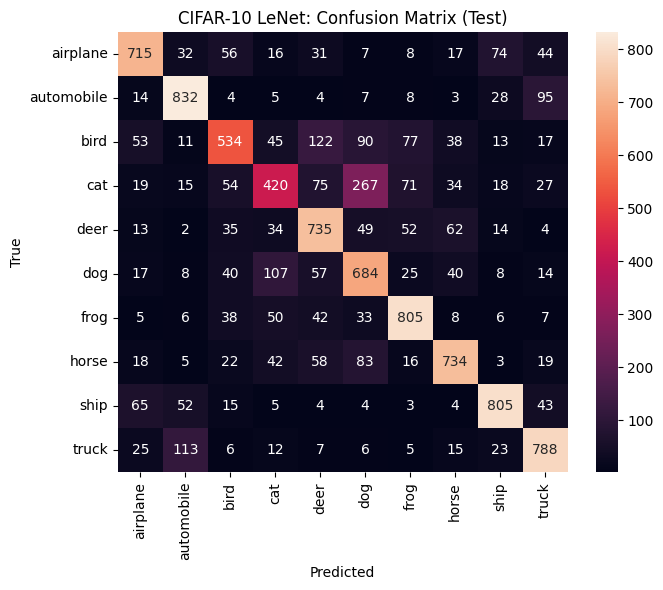

[eval] Classification report:

              precision    recall  f1-score   support

    airplane     0.7574    0.7150    0.7356      1000
  automobile     0.7732    0.8320    0.8015      1000
        bird     0.6642    0.5340    0.5920      1000
         cat     0.5707    0.4200    0.4839      1000
        deer     0.6476    0.7350    0.6885      1000
         dog     0.5561    0.6840    0.6135      1000
        frog     0.7523    0.8050    0.7778      1000
       horse     0.7686    0.7340    0.7509      1000
        ship     0.8115    0.8050    0.8082      1000
       truck     0.7448    0.7880    0.7658      1000

    accuracy                         0.7052     10000
   macro avg     0.7046    0.7052    0.7018     10000
weighted avg     0.7046    0.7052    0.7018     10000


[plot] Plotting training curves...



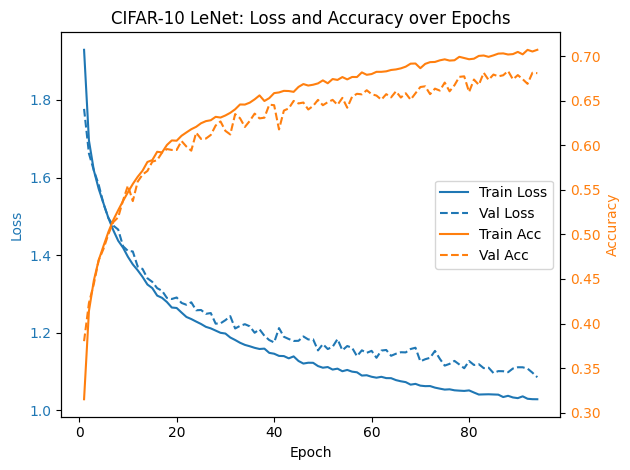

[done] Finished.



In [3]:
# ======================================================================
# 0) DEVICE SELECTION (CUDA -> MPS -> CPU) + SEED
# ======================================================================
import time, os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pick best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[device] Using Apple Metal (MPS) device")
else:
    device = torch.device("cpu")
    print("[device] Using CPU")

torch.manual_seed(0)
print()  # line skip


# ======================================================================
# 1) MODEL: LeNet-style CNN for CIFAR-10 (32x32x3)
#    Conv(3->6, 5x5) -> ReLU -> Pool
#    Conv(6->16, 5x5) -> ReLU -> Pool
#    Flatten -> FC(120) -> ReLU -> FC(84) -> ReLU -> FC(10)
#    He init for conv/linear
# ======================================================================
class LeNetCIFAR(nn.Module):
    def __init__(self, num_classes=10, use_maxpool=False):
        super().__init__()
        Pool = nn.MaxPool2d if use_maxpool else nn.AvgPool2d

        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2, bias=False),  # 32x32 -> 32x32
            nn.ReLU(inplace=True),
            Pool(kernel_size=2, stride=2),                                     # 32 -> 16

            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=False), # 16x16 -> 12x12
            nn.ReLU(inplace=True),
            Pool(kernel_size=2, stride=2)                                      # 12 -> 6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                      # 16*6*6 = 576
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)         # logits
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Always start fresh
model = LeNetCIFAR(use_maxpool=True).to(device)  # set to False to use AvgPool (classic LeNet)
print("[model] Initialized LeNetCIFAR")
print()  # line skip


# ======================================================================
# 2) DATA: CIFAR-10 with augmentation + normalization
# ======================================================================
print("[data] Preparing CIFAR-10 (train/val/test)...")
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

root = "./data"
full_train = datasets.CIFAR10(root=root, train=True,  download=True, transform=train_tf)
testset    = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)

# 45k/5k split for train/val
train_size = 45_000
val_size   = len(full_train) - train_size
trainset, valset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

pin_mem = (device.type == "cuda")
num_workers = min(4, os.cpu_count() or 0)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(valset,   batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"[data] Sizes -> train: {len(trainset)}, val: {len(valset)}, test: {len(testset)}")
print()  # line skip


# ======================================================================
# 3) TRAINING SETUP (AdamW + weight decay, CE w/ mild label smoothing)
# ======================================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-4)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

EPOCHS = 1000
patience = 10
min_delta = 0.0
best_val = float("inf")
since_improved = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
print("[train] Setup complete. Starting training...")
print()  # line skip


# ======================================================================
# 4) TRAINING LOOP WITH EARLY STOPPING + TIMING
# ======================================================================
train_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total          += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # Validate
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss    += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)

    val_loss = v_loss / v_total
    val_acc  = v_correct / v_total

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"[epoch {epoch:02d}] "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping on val_loss
    if val_loss < best_val - min_delta:
        best_val = val_loss
        since_improved = 0
        torch.save({"model_state": model.state_dict(), "history": history}, "cifar10_lenet_best.pth")
        print("  [checkpoint] New best model saved.")
    else:
        since_improved += 1
        print(f"  [early-stop] No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print("  [early-stop] Patience exceeded — stopping.")
            break

total_train_time = time.time() - train_start_time
print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

# Load best model
ckpt = torch.load("cifar10_lenet_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
history = ckpt["history"]


# ======================================================================
# 5) EVALUATION ON TEST SET + CONFUSION MATRIX + REPORT
# ======================================================================
print("[eval] Evaluating on CIFAR-10 test set...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y.numpy())

y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()
classes = testset.classes
test_acc = (y_true == y_pred).mean()
print(f"[eval] Test accuracy: {test_acc:.4f}\n")

# Confusion Matrix (default colormap)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)  # default cmap
plt.title("CIFAR-10 LeNet: Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("[eval] Classification report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
print()  # line skip


# ======================================================================
# 6) TRAIN/VAL LOSS + ACCURACY PLOT (tab:blue / tab:orange)
# ======================================================================
print("[plot] Plotting training curves...\n")
epochs_range = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs_range, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs_range, history["val_loss"],   label="Val Loss",   color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs_range, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs_range, history["val_acc"],   label="Val Acc",   color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.title("CIFAR-10 LeNet: Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

print("[done] Finished.\n")

### A More Modern CNN

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[model] Initialized CIFAR10_CNN

[data] Preparing CIFAR-10 (train/val/test)...
Files already downloaded and verified
Files already downloaded and verified
[data] Sizes -> train: 45000, val: 5000, test: 10000

[train] Setup complete. Starting training...

[epoch 01] train: loss=1.6236, acc=0.4359 | val: loss=1.4327, acc=0.5274 | time: 3.85s
  [checkpoint] New best model saved.
[epoch 02] train: loss=1.2969, acc=0.5834 | val: loss=1.2511, acc=0.6152 | time: 3.77s
  [checkpoint] New best model saved.
[epoch 03] train: loss=1.1465, acc=0.6525 | val: loss=1.2255, acc=0.6202 | time: 3.59s
  [checkpoint] New best model saved.
[epoch 04] train: loss=1.0453, acc=0.6976 | val: loss=1.0213, acc=0.7024 | time: 3.63s
  [checkpoint] New best model saved.
[epoch 05] train: loss=0.9756, acc=0.7271 | val: loss=0.9342, acc=0.7440 | time: 3.84s
  [checkpoint] New best model saved.
[epoch 06] train: loss=0.9198, acc=0.7529 | val: loss=0.8944, acc=0.7674

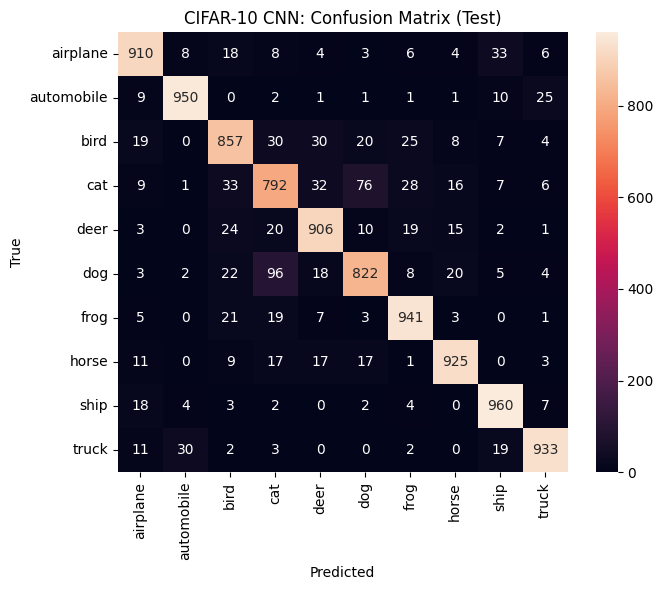

[eval] Classification report:

              precision    recall  f1-score   support

    airplane     0.9118    0.9100    0.9109      1000
  automobile     0.9548    0.9500    0.9524      1000
        bird     0.8665    0.8570    0.8617      1000
         cat     0.8008    0.7920    0.7964      1000
        deer     0.8926    0.9060    0.8993      1000
         dog     0.8616    0.8220    0.8414      1000
        frog     0.9092    0.9410    0.9248      1000
       horse     0.9325    0.9250    0.9287      1000
        ship     0.9204    0.9600    0.9398      1000
       truck     0.9424    0.9330    0.9377      1000

    accuracy                         0.8996     10000
   macro avg     0.8993    0.8996    0.8993     10000
weighted avg     0.8993    0.8996    0.8993     10000


[plot] Plotting training curves...



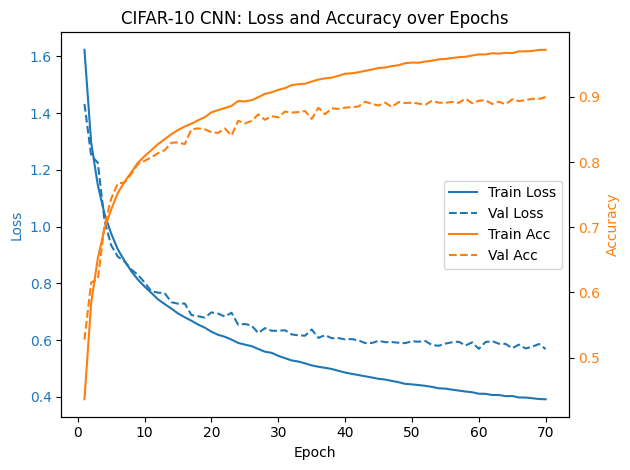

[done] Finished.



In [4]:
# ======================================================================
# 0) DEVICE SELECTION (CUDA -> MPS -> CPU) + SEED
# ======================================================================
import time, os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pick best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[device] Using Apple Metal (MPS) device")
else:
    device = torch.device("cpu")
    print("[device] Using CPU")

torch.manual_seed(0)
print()  # line skip

# ======================================================================
# 1) MODEL: Compact CNN for CIFAR-10
#    - 3x3 conv stacks, BatchNorm + ReLU
#    - Strided conv for downsampling
#    - Dropout for regularization
#    - Global Average Pool -> Linear(10)
#    - He initialization
# ======================================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Dropout(p_drop)
        )
    def forward(self, x):
        return self.block(x)

class CIFAR10_CNN(nn.Module):
    def __init__(self, num_classes=10, p_drop=0.2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.stage1 = ConvBlock(64, 128, stride=2, p_drop=p_drop)   # 16x16
        self.stage2 = ConvBlock(128, 256, stride=2, p_drop=p_drop)  # 8x8
        self.stage3 = ConvBlock(256, 256, stride=2, p_drop=p_drop)  # 4x4
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.head(x)
        return x

# Always start fresh
model = CIFAR10_CNN().to(device)
print("[model] Initialized CIFAR10_CNN")
print()  # line skip

# ======================================================================
# 2) DATA: CIFAR-10 with augmentation + normalization
# ======================================================================
print("[data] Preparing CIFAR-10 (train/val/test)...")
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

root = "../data"
full_train = datasets.CIFAR10(root=root, train=True,  download=True, transform=train_tf)
testset    = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)

# 45k/5k split for train/val
train_size = 45000
val_size   = len(full_train) - train_size
trainset, valset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

pin_mem = (device.type == "cuda")
num_workers = min(4, os.cpu_count() or 0)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(valset,   batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"[data] Sizes -> train: {len(trainset)}, val: {len(valset)}, test: {len(testset)}")
print()  # line skip

# ======================================================================
# 3) TRAINING SETUP
#    - AdamW + weight decay
#    - CE w/ label smoothing (mild)
# ======================================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

EPOCHS = 1000
patience = 10         # early stopping patience
min_delta = 0.0       # minimum improvement to reset patience
MONITOR = "loss"      # choose "loss" or "acc" for early stopping metric

if MONITOR == "loss":
    best_metric = float("inf")
else:
    best_metric = 0.0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
print("[train] Setup complete. Starting training...")
print()  # line skip

# ======================================================================
# 4) TRAINING LOOP WITH EARLY STOPPING + TIMING
# ======================================================================
train_start_time = time.time()
since_improved = 0

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total          += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # Validate
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss    += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)

    val_loss = v_loss / v_total
    val_acc  = v_correct / v_total

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"[epoch {epoch:02d}] "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping 
    improved = False
    if MONITOR == "loss":
        if val_loss < best_metric - min_delta:
            best_metric = val_loss
            improved = True
    else:  # MONITOR == "acc"
        if val_acc > best_metric + min_delta:
            best_metric = val_acc
            improved = True

    if improved:
        since_improved = 0
        torch.save({"model_state": model.state_dict(), "history": history, "monitor": MONITOR,
                    "best_metric": best_metric}, "cifar10_cnn_best.pth")
        print("  [checkpoint] New best model saved.")
    else:
        since_improved += 1
        print(f"  [early-stop] No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print("  [early-stop] Patience exceeded — stopping.")
            break

total_train_time = time.time() - train_start_time
print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

# Load best model
ckpt = torch.load("cifar10_cnn_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
history = ckpt["history"]
MONITOR  = ckpt.get("monitor", MONITOR)

# ======================================================================
# 5) EVALUATION ON TEST SET + CONFUSION MATRIX + REPORT
# ======================================================================
print("[eval] Evaluating on CIFAR-10 test set...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y.numpy())

y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()
classes = testset.classes
test_acc = (y_true == y_pred).mean()
print(f"[eval] Test accuracy: {test_acc:.4f}\n")

# Confusion matrix (default colormap)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)  # default cmap
plt.title("CIFAR-10 CNN: Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("[eval] Classification report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
print()  # line skip

# ======================================================================
# 6) TRAIN/VAL LOSS + ACCURACY PLOT (tab:blue / tab:orange)
# ======================================================================
print("[plot] Plotting training curves...\n")
epochs_range = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs_range, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs_range, history["val_loss"],   label="Val Loss",   color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs_range, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs_range, history["val_acc"],   label="Val Acc",   color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.title("CIFAR-10 CNN: Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

print("[done] Finished.\n")

### Dogs vs Cats

Let's now use a similar model for a much higher resolution dataset of cats and dogs. Here are some of the images:

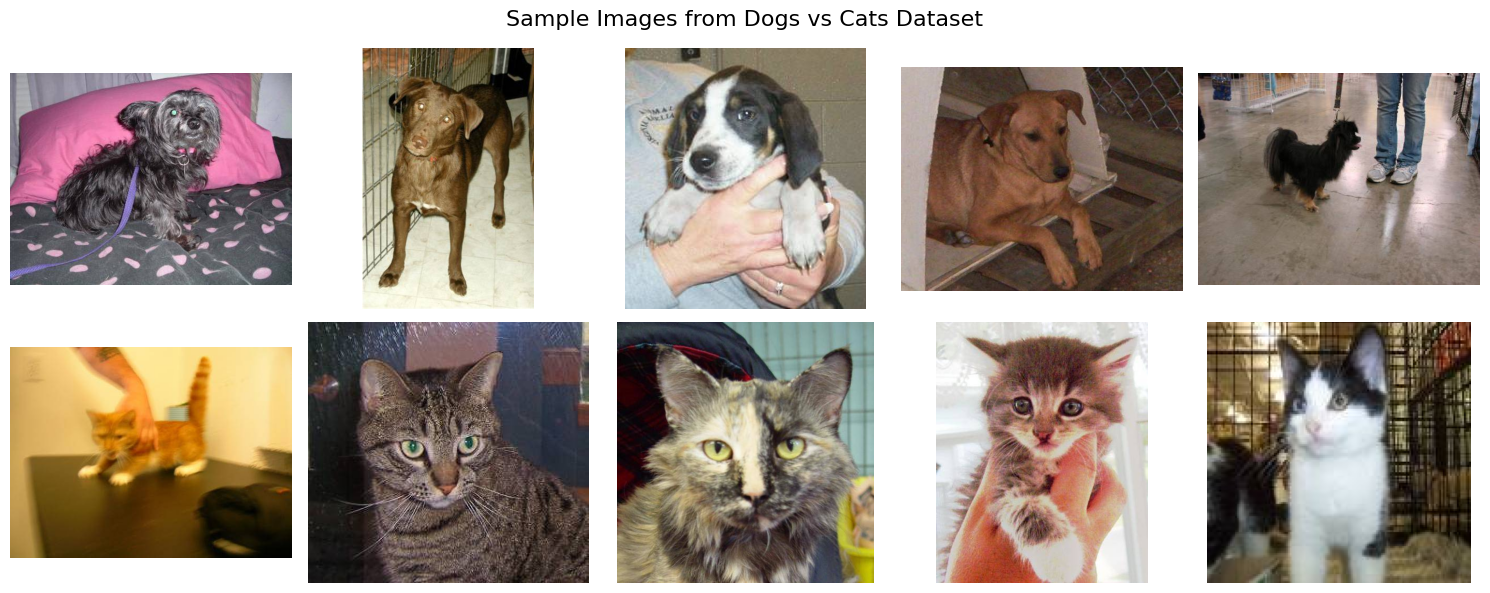

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to dataset
data_dir = "../data/dogs-vs-cats"
categories = ["dog", "cat"]

# How many images per category to display
n_per_class = 5

fig, axes = plt.subplots(len(categories), n_per_class, figsize=(n_per_class * 3, len(categories) * 3))

for row_idx, category in enumerate(categories):
    folder = os.path.join(data_dir, category)
    files = sorted(os.listdir(folder))[:n_per_class]  # first few files
    for col_idx, fname in enumerate(files):
        img_path = os.path.join(folder, fname)
        try:
            img = Image.open(img_path).convert("RGB")
            axes[row_idx, col_idx].imshow(img)
            axes[row_idx, col_idx].axis("off")
            if col_idx == 0:
                axes[row_idx, col_idx].set_ylabel(category.capitalize(), fontsize=14)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

plt.suptitle("Sample Images from Dogs vs Cats Dataset", fontsize=16)
plt.tight_layout()
plt.show()

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[model] Initialized DogsCatsCNN

[data] Preparing Dogs vs Cats (train/val/test) from ImageFolder...
[data] Classes: ['cat', 'dog']
[data] Sizes -> train: 20000, val: 2500, test: 2500

[train] Setup complete. Starting training...

[epoch 01] train: loss=0.6015, acc=0.6822 | val: loss=0.7613, acc=0.6336 | time: 49.84s
  [checkpoint] New best model saved.
[epoch 02] train: loss=0.5095, acc=0.7643 | val: loss=0.6380, acc=0.6792 | time: 49.30s
  [checkpoint] New best model saved.
[epoch 03] train: loss=0.4487, acc=0.8059 | val: loss=0.5978, acc=0.7340 | time: 49.23s
  [checkpoint] New best model saved.
[epoch 04] train: loss=0.3902, acc=0.8447 | val: loss=0.4016, acc=0.8524 | time: 49.25s
  [checkpoint] New best model saved.
[epoch 05] train: loss=0.3586, acc=0.8616 | val: loss=0.4121, acc=0.8280 | time: 49.28s
  [early-stop] No improvement (1/10)
[epoch 06] train: loss=0.3295, acc=0.8778 | val: loss=0.4337, acc=0.8408 | time: 49.20s
  [e

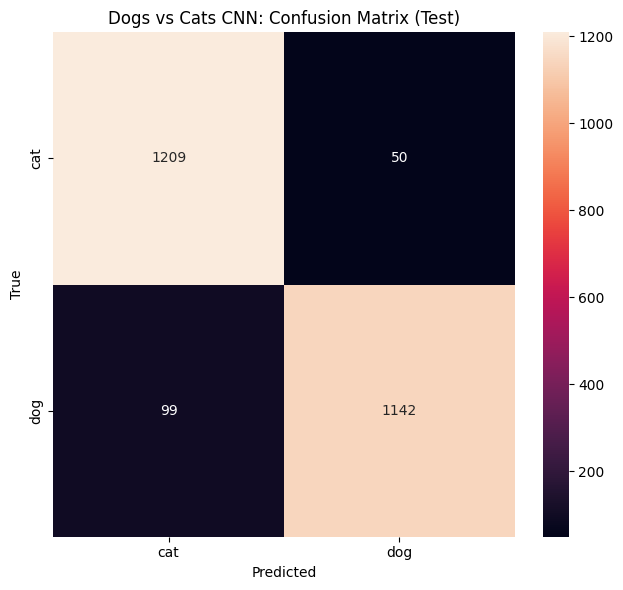

[eval] Classification report:

              precision    recall  f1-score   support

         cat     0.9243    0.9603    0.9420      1259
         dog     0.9581    0.9202    0.9388      1241

    accuracy                         0.9404      2500
   macro avg     0.9412    0.9403    0.9404      2500
weighted avg     0.9411    0.9404    0.9404      2500


[plot] Plotting training curves...



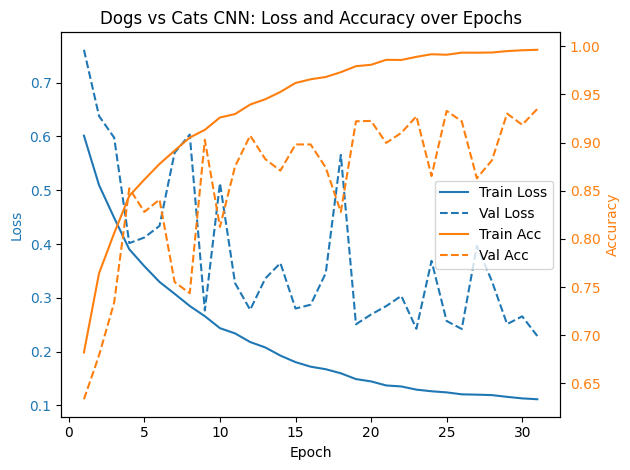

[done] Finished.



In [6]:
# ======================================================================
# 0) DEVICE SELECTION (CUDA -> MPS -> CPU) + SEED
# ======================================================================
import time, os, math
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pick best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[device] Using Apple Metal (MPS) device")
else:
    device = torch.device("cpu")
    print("[device] Using CPU")

torch.manual_seed(0)
print()  # line skip


# ======================================================================
# 1) MODEL: Compact CNN for Dogs vs Cats
#    - 3x3 conv stacks, BatchNorm + ReLU
#    - Strided conv for downsampling
#    - Dropout for regularization
#    - Global Average Pool -> Linear(2)
#    - He initialization
# ======================================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Dropout(p_drop)
        )
    def forward(self, x):
        return self.block(x)

class DogsCatsCNN(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.stage1 = ConvBlock(64, 128, stride=2, p_drop=p_drop)
        self.stage2 = ConvBlock(128, 256, stride=2, p_drop=p_drop)
        self.stage3 = ConvBlock(256, 256, stride=2, p_drop=p_drop)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.head(x)
        return x

# Always start fresh
model = DogsCatsCNN().to(device)
print("[model] Initialized DogsCatsCNN")
print()  # line skip


# ======================================================================
# 2) DATA: Dogs vs Cats (ImageFolder) with augmentation + normalization
#    Folder structure expected:
#      ../data/dogs-vs-cats/
#          cat/  <images...>
#          dog/  <images...>
#    Images may be different resolutions; we use RandomResizedCrop(224)
# ======================================================================
print("[data] Preparing Dogs vs Cats (train/val/test) from ImageFolder...")

# Use ImageNet stats (works well for natural images)
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

root = "../data/dogs-vs-cats"
full_dataset = datasets.ImageFolder(root=root, transform=train_tf)  # temp transform; will reset for val/test after split

# Split train/val/test (e.g., 80/10/10)
N = len(full_dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    full_dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

# Assign transforms per split (val/test should not use heavy train augments)
train_ds.dataset.transform = train_tf
val_ds.dataset.transform   = test_tf
test_ds.dataset.transform  = test_tf

classes = full_dataset.classes  # e.g., ['cats', 'dogs'] (alphabetical)
print(f"[data] Classes: {classes}")

pin_mem = (device.type == "cuda")
num_workers = min(4, os.cpu_count() or 0)
train_loader = DataLoader(train_ds, batch_size=64,  shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"[data] Sizes -> train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
print()  # line skip


# ======================================================================
# 3) TRAINING SETUP
#    - AdamW + weight decay
#    - CrossEntropy with mild label smoothing
# ======================================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.03)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

EPOCHS = 1000
patience = 10         # early stopping patience
min_delta = 0.0       # minimum improvement to reset patience
best_val = float("inf")
since_improved = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
print("[train] Setup complete. Starting training...")
print()  # line skip


# ======================================================================
# 4) TRAINING LOOP WITH EARLY STOPPING + TIMING
# ======================================================================
train_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total          += x.size(0)

    train_loss = running_loss / total if total else 0.0
    train_acc  = running_correct / total if total else 0.0

    # Validate
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss    += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)

    val_loss = v_loss / v_total if v_total else float("inf")
    val_acc  = v_correct / v_total if v_total else 0.0

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"[epoch {epoch:02d}] "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping on val_loss
    if val_loss < best_val - min_delta:
        best_val = val_loss
        since_improved = 0
        torch.save({"model_state": model.state_dict(), "history": history, "classes": classes},
                   "dogs_cats_cnn_best.pth")
        print("  [checkpoint] New best model saved.")
    else:
        since_improved += 1
        print(f"  [early-stop] No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print("  [early-stop] Patience exceeded — stopping.")
            break

total_train_time = time.time() - train_start_time
print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

# Load best model
ckpt = torch.load("dogs_cats_cnn_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
history = ckpt["history"]
classes = ckpt["classes"]


# ======================================================================
# 5) EVALUATION ON TEST SET + CONFUSION MATRIX + REPORT
# ======================================================================
print("[eval] Evaluating on Dogs vs Cats test set...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y.numpy())

y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()
test_acc = (y_true == y_pred).mean()
print(f"[eval] Test accuracy: {test_acc:.4f}\n")

# Confusion matrix (default colormap)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
plt.figure(figsize=(6.5,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)  # default cmap
plt.title("Dogs vs Cats CNN: Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("[eval] Classification report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
print()  # line skip


# ======================================================================
# 6) TRAIN/VAL LOSS + ACCURACY PLOT (tab:blue / tab:orange)
# ======================================================================
print("[plot] Plotting training curves...\n")
epochs_range = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs_range, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs_range, history["val_loss"],   label="Val Loss",   color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs_range, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs_range, history["val_acc"],   label="Val Acc",   color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.title("Dogs vs Cats CNN: Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

print("[done] Finished.\n")


## Lecture 12 - Deep CNNs: AlexNet, VGGNet

### AlexNet Experiment

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[model] Initialized AlexNet (from scratch)

[data] Preparing Dogs vs Cats (train/val/test) with 224x224 transforms...
[data] Classes: ['cat', 'dog']
[data] Sizes -> train: 20000, val: 2500, test: 2500

[train] Setup complete. Starting training...

[epoch 01] train: loss=0.7694, acc=0.5379 | val: loss=0.6766, acc=0.5860 | time: 19.52s
  [checkpoint] New best model saved.
[epoch 02] train: loss=0.6525, acc=0.6205 | val: loss=0.6559, acc=0.6508 | time: 19.63s
  [checkpoint] New best model saved.
[epoch 03] train: loss=0.6048, acc=0.6868 | val: loss=0.6008, acc=0.6716 | time: 19.60s
  [checkpoint] New best model saved.
[epoch 04] train: loss=0.5447, acc=0.7399 | val: loss=0.5206, acc=0.7548 | time: 19.77s
  [checkpoint] New best model saved.
[epoch 05] train: loss=0.4929, acc=0.7790 | val: loss=0.4425, acc=0.8112 | time: 19.63s
  [checkpoint] New best model saved.
[epoch 06] train: loss=0.4367, acc=0.8216 | val: loss=0.4331, acc=0.8204 |

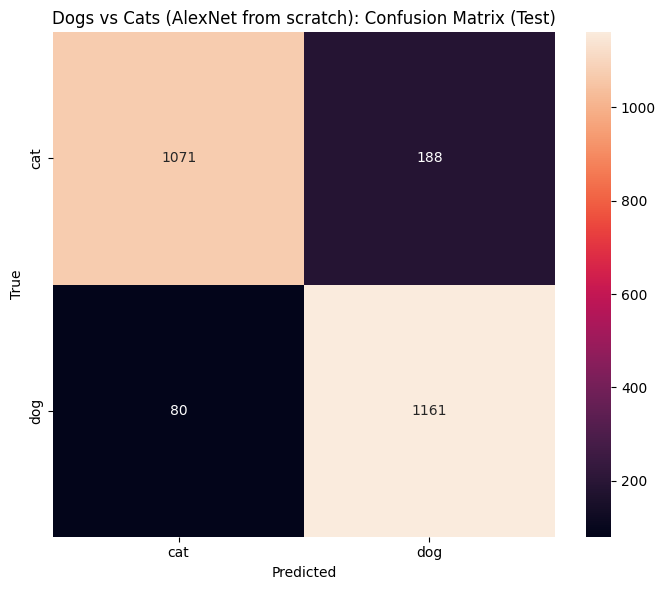

[eval] Classification report:

              precision    recall  f1-score   support

         cat     0.9305    0.8507    0.8888      1259
         dog     0.8606    0.9355    0.8965      1241

    accuracy                         0.8928      2500
   macro avg     0.8956    0.8931    0.8927      2500
weighted avg     0.8958    0.8928    0.8926      2500


[plot] Plotting training curves...



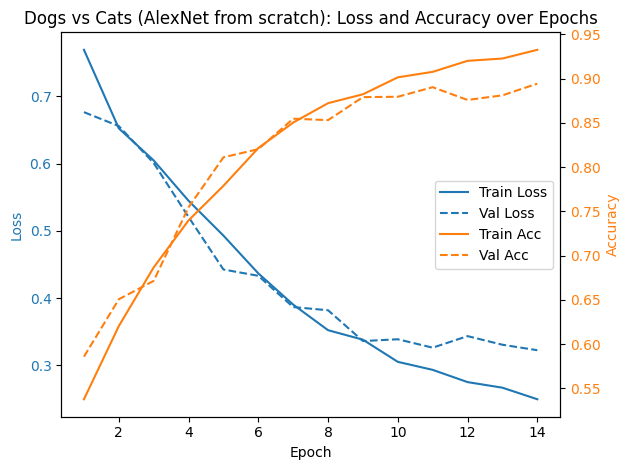

[done] Finished.



In [7]:
# ======================================================================
# 0) DEVICE SELECTION (CUDA -> MPS -> CPU) + SEED
# ======================================================================
import time, os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pick best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[device] Using Apple Metal (MPS) device")
else:
    device = torch.device("cpu")
    print("[device] Using CPU")

torch.manual_seed(0)
print()  # line skip


# ======================================================================
# 1) MODEL: AlexNet (from scratch) for Dogs vs Cats
#    - Classic stem: 11x11/s4 -> LRN -> MaxPool
#    - 5x5 -> LRN -> MaxPool
#    - 3x3, 3x3, 3x3 -> MaxPool
#    - Classifier: 4096 -> 4096 -> 2  (with Dropout 0.5)
#    - He initialization for conv/linear
#    Notes:
#      * We resize images to 224x224, matching classic AlexNet input.
#      * Use AdaptiveAvgPool2d((6,6)) before classifier for robustness.
# ======================================================================
class AlexNet(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2, bias=False),  # 224 -> 55
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),                               # 55 -> 27

            nn.Conv2d(96, 256, kernel_size=5, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),                               # 27 -> 13

            nn.Conv2d(256, 384, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                               # 13 -> 6
        )

        # Keep it robust if input dims differ slightly; force 6x6 like classic AlexNet
        self.adapt = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Flatten(),                       # 256 * 6 * 6 = 9216
            nn.Dropout(p_drop),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)        # logits
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.adapt(x)
        x = self.classifier(x)
        return x

# Always start fresh
model = AlexNet().to(device)
print("[model] Initialized AlexNet (from scratch)")
print()  # line skip


# ======================================================================
# 2) DATA: Dogs vs Cats (ImageFolder) with augmentation + normalization
#    Expected structure:
#      ../data/dogs-vs-cats/
#          cat/  *.jpg, *.png, ...
#          dog/  *.jpg, *.png, ...
#    Images may have different resolutions; standardized to 224x224.
# ======================================================================
print("[data] Preparing Dogs vs Cats (train/val/test) with 224x224 transforms...")

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

root = "../data/dogs-vs-cats"
full_ds = datasets.ImageFolder(root=root, transform=train_tf)  # temporary; will set per-split transforms
classes = full_ds.classes  # ['cats','dogs'] (alphabetical)
print(f"[data] Classes: {classes}")

# 80/10/10 split
N = len(full_ds)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_ds.dataset.transform = train_tf
val_ds.dataset.transform   = test_tf
test_ds.dataset.transform  = test_tf

pin_mem = (device.type == "cuda")
num_workers = min(4, os.cpu_count() or 0)
train_loader = DataLoader(train_ds, batch_size=64,  shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"[data] Sizes -> train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
print()  # line skip


# ======================================================================
# 3) TRAINING SETUP
#    - CrossEntropy with mild label smoothing
#    - Optimizer: SGD + momentum + weight decay (AlexNet-style)
# ======================================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

EPOCHS = 1000
patience = 10
min_delta = 0.0
best_val = float("inf")
since_improved = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
print("[train] Setup complete. Starting training...")
print()  # line skip


# ======================================================================
# 4) TRAINING LOOP WITH EARLY STOPPING + TIMING
# ======================================================================
train_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total          += x.size(0)

    train_loss = running_loss / total if total else 0.0
    train_acc  = running_correct / total if total else 0.0

    # Validate
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss    += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)

    val_loss = v_loss / v_total if v_total else float("inf")
    val_acc  = v_correct / v_total if v_total else 0.0

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"[epoch {epoch:02d}] "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping on val_loss
    if val_loss < best_val - min_delta:
        best_val = val_loss
        since_improved = 0
        torch.save({
            "model_state": model.state_dict(),
            "history": history,
            "classes": classes
        }, "dogs_vs_cats_alexnet_scratch_best.pth")
        print("  [checkpoint] New best model saved.")
    else:
        since_improved += 1
        print(f"  [early-stop] No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print("  [early-stop] Patience exceeded — stopping.")
            break

total_train_time = time.time() - train_start_time
print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

# Load best model
ckpt = torch.load("dogs_vs_cats_alexnet_scratch_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
history = ckpt["history"]
classes = ckpt["classes"]


# ======================================================================
# 5) EVALUATION ON TEST SET + CONFUSION MATRIX + REPORT
# ======================================================================
print("[eval] Evaluating on Dogs vs Cats test set...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y.numpy())

y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()
test_acc = (y_true == y_pred).mean()
print(f"[eval] Test accuracy: {test_acc:.4f}\n")

# Confusion Matrix (default colormap)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)  # default cmap
plt.title("Dogs vs Cats (AlexNet from scratch): Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("[eval] Classification report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
print()  # line skip


# ======================================================================
# 6) TRAIN/VAL LOSS + ACCURACY PLOT (tab:blue / tab:orange)
# ======================================================================
print("[plot] Plotting training curves...\n")
epochs_range = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs_range, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs_range, history["val_loss"],   label="Val Loss",   color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs_range, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs_range, history["val_acc"],   label="Val Acc",   color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.title("Dogs vs Cats (AlexNet from scratch): Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

print("[done] Finished.\n")


### VGGNet Experiment

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[model] Reinitialized: VGGNet (BN) for Dogs vs Cats

[data] Preparing Dogs vs Cats (train/val/test) with 224x224 transforms...
[data] Classes: ['cat', 'dog']
[data] Sizes -> train: 20000, val: 2500, test: 2500

[train] Setup complete. Starting training...

[epoch 01] train: loss=1.4525, acc=0.5218 | val: loss=0.7931, acc=0.5392 | time: 97.94s
  [checkpoint] New best model saved.
[epoch 02] train: loss=0.7332, acc=0.5625 | val: loss=0.6382, acc=0.6492 | time: 97.87s
  [checkpoint] New best model saved.
[epoch 03] train: loss=0.6097, acc=0.6843 | val: loss=0.5943, acc=0.6732 | time: 97.63s
  [checkpoint] New best model saved.
[epoch 04] train: loss=0.5356, acc=0.7488 | val: loss=0.5079, acc=0.7704 | time: 97.09s
  [checkpoint] New best model saved.
[epoch 05] train: loss=0.4578, acc=0.8032 | val: loss=0.4798, acc=0.7980 | time: 96.67s
  [checkpoint] New best model saved.
[epoch 06] train: loss=0.3750, acc=0.8519 | val: loss=0.5682, acc

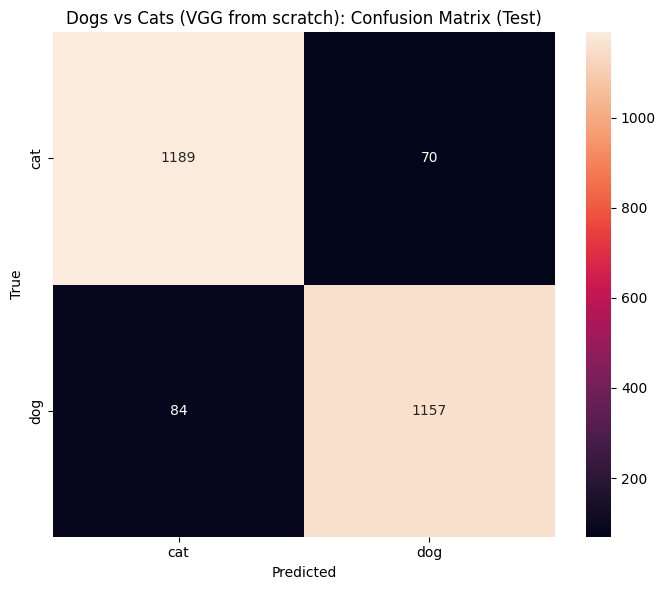

[eval] Classification report:

              precision    recall  f1-score   support

         cat     0.9340    0.9444    0.9392      1259
         dog     0.9430    0.9323    0.9376      1241

    accuracy                         0.9384      2500
   macro avg     0.9385    0.9384    0.9384      2500
weighted avg     0.9385    0.9384    0.9384      2500


[plot] Plotting training curves...



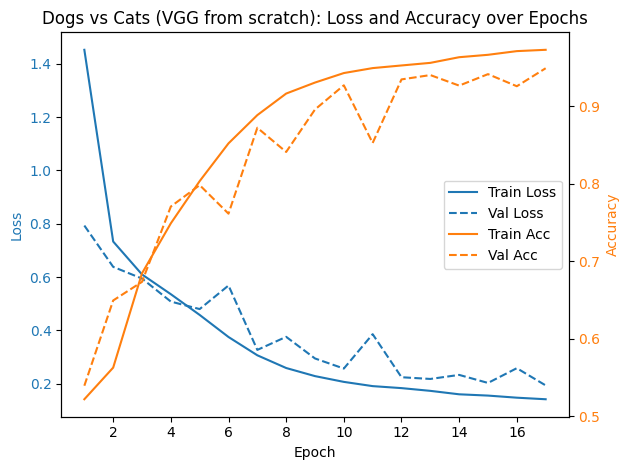

[done] Finished.



In [9]:
# ======================================================================
# 0) DEVICE SELECTION (CUDA -> MPS -> CPU) + SEED
# ======================================================================
import time, os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pick best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[device] Using Apple Metal (MPS) device")
else:
    device = torch.device("cpu")
    print("[device] Using CPU")

torch.manual_seed(0)
print()  # line skip


# ======================================================================
# 1) MODEL: VGGNet (from scratch) for Dogs vs Cats (VGG16-style)
#    - Explicitly define all layers here
#    - Stacks of 3x3 conv + ReLU, MaxPool to downsample
#    - AdaptiveAvgPool2d to 7x7, then 4096 -> 4096 -> 2 classifier with Dropout
#    - He initialization for conv/linear
# ======================================================================

import torch.nn as nn

class VGGNet(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.3):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 2
            nn.Conv2d(64, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 3
            nn.Conv2d(128, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 4
            nn.Conv2d(256, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 5
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Re-init model
model = VGGNet().to(device)
print("[model] Reinitialized: VGGNet (BN) for Dogs vs Cats\n")



# ======================================================================
# 2) DATA: Dogs vs Cats (ImageFolder) with augmentation + normalization
#    Expected structure:
#      ../data/dogs-vs-cats/
#          cats/  *.jpg, *.png, ...
#          dogs/  *.jpg, *.png, ...
#    Standardize to 224x224 as in VGG/AlexNet papers.
# ======================================================================
print("[data] Preparing Dogs vs Cats (train/val/test) with 224x224 transforms...")

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

root = "../data/dogs-vs-cats"
full_ds = datasets.ImageFolder(root=root, transform=train_tf)  # temporary; will set per-split transforms
classes = full_ds.classes  # e.g., ['cats','dogs']
print(f"[data] Classes: {classes}")

# 80/10/10 split
N = len(full_ds)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_ds.dataset.transform = train_tf
val_ds.dataset.transform   = test_tf
test_ds.dataset.transform  = test_tf

pin_mem = (device.type == "cuda")
num_workers = min(4, os.cpu_count() or 0)
# VGG is heavy: keep moderate batch sizes
train_loader = DataLoader(train_ds, batch_size=64,  shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(val_ds,   batch_size=128,  shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(test_ds,  batch_size=128,  shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"[data] Sizes -> train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
print()  # line skip


# ======================================================================
# 3) TRAINING SETUP
#    - CrossEntropy with mild label smoothing
#    - Optimizer: SGD + momentum + weight decay (VGG-style)
# ======================================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.03)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

EPOCHS = 1000
patience = 10
min_delta = 0.0
best_val = float("inf")
since_improved = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
print("[train] Setup complete. Starting training...")
print()

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()


# ======================================================================
# 4) TRAINING LOOP WITH EARLY STOPPING + TIMING
# ======================================================================
train_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total          += x.size(0)

    train_loss = running_loss / total if total else 0.0
    train_acc  = running_correct / total if total else 0.0

    # Validate
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss    += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)

    val_loss = v_loss / v_total if v_total else float("inf")
    val_acc  = v_correct / v_total if v_total else 0.0

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"[epoch {epoch:02d}] "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping on val_loss
    if val_loss < best_val - min_delta:
        best_val = val_loss
        since_improved = 0
        torch.save({
            "model_state": model.state_dict(),
            "history": history,
            "classes": classes
        }, "dogs_vs_cats_vgg_best.pth")
        print("  [checkpoint] New best model saved.")
    else:
        since_improved += 1
        print(f"  [early-stop] No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print("  [early-stop] Patience exceeded — stopping.")
            break

total_train_time = time.time() - train_start_time
print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

# Load best model
ckpt = torch.load("dogs_vs_cats_vgg_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
history = ckpt["history"]
classes = ckpt["classes"]


# ======================================================================
# 5) EVALUATION ON TEST SET + CONFUSION MATRIX + REPORT
# ======================================================================
print("[eval] Evaluating on Dogs vs Cats test set...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y.numpy())

y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()
test_acc = (y_true == y_pred).mean()
print(f"[eval] Test accuracy: {test_acc:.4f}\n")

# Confusion Matrix (default colormap)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)  # default cmap
plt.title("Dogs vs Cats (VGG from scratch): Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("[eval] Classification report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
print()  # line skip


# ======================================================================
# 6) TRAIN/VAL LOSS + ACCURACY PLOT (tab:blue / tab:orange)
# ======================================================================
print("[plot] Plotting training curves...\n")
epochs_range = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs_range, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs_range, history["val_loss"],   label="Val Loss",   color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs_range, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs_range, history["val_acc"],   label="Val Acc",   color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.title("Dogs vs Cats (VGG from scratch): Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

print("[done] Finished.\n")

### Reusable Training Function for CNNs and Image Datasets

The code above is very functional, but it requires rewriting the same bits of code over and over for preparing the datasets, training, and assessing performance. Here, we make a reusable function that allows us to input our dataset, model, and hyperparameters, which it then takes to train, save, and evaluate model performance.

In [3]:
# ======================================================================
# run_imagefolder_experiment
#
# End-to-end PyTorch training/evaluation pipeline for image classification
# using datasets stored in ImageFolder format.
#
# Features:
#   • Loads and splits dataset into train/val/test sets with configurable ratios.
#   • Applies augmentation to training set, standard transforms to val/test.
#   • Uses tqdm progress bars for batch-level metrics during training/validation/testing.
#   • Supports AdamW or SGD optimizers, label smoothing, gradient clipping.
#   • Includes ReduceLROnPlateau scheduler (default patience=10, factor=0.5).
#   • Includes early stopping (default patience=25) on validation metric.
#   • Saves best model checkpoint based on chosen monitor ("loss" or "acc").
#   • Evaluates on held-out test set with accuracy, confusion matrix, and classification report.
#   • Plots twin-axis training curves for loss and accuracy.
#
# Args:
#   data_dir (str): Root folder containing subfolders for each class.
#   model (nn.Module): Model architecture to train.
#   [other keyword args control preprocessing, training, and hyperparameters]
#
# Returns:
#   dict: history, best test accuracy, classes, checkpoint path, device info, total train time.
# ======================================================================
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import time
import torch
import torch.nn as nn

from collections import Counter
from notebook.services.config import ConfigManager
from sklearn.metrics import confusion_matrix, classification_report
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.auto import tqdm

cm = ConfigManager()
cm.update('NotebookApp', {
    'iopub_msg_rate_limit': 50000,
    'rate_limit_window': 10.0
})

# ======================================================================
# Helper Functions
def split_counts(split):
    idxs = split.indices if hasattr(split, "indices") else range(len(split))
    labels = [split.dataset.samples[i][1] for i in idxs]
    return Counter(labels)

def current_lr(optim_):
    return optim_.param_groups[0]["lr"]

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()
# ======================================================================

def run_imagefolder_experiment(
    data_dir,
    model,
    *,
    # ----- Transforms -----
    img_size = 224,
    resize_side = 256,
    augment = True,
    normalize_stats = (
        (0.485, 0.456, 0.406),  # mean (ImageNet defaults)
        (0.229, 0.224, 0.225),  # standard deviation
    ),
    # ----- Split fractions -----
    splits = (0.8, 0.1, 0.1),   # train/val/test fractions
    # ----- DataLoader -----
    batch_train = 32,
    batch_eval = 64,
    num_workers = 4,
    # ----- Optimizer -----
    optimizer_name = "adamw",   # "adamw" or "sgd"
    lr = 3e-4,
    weight_decay: 5e-4,
    momentum = 0.9,             # used if optimizer_name == "sgd"
    label_smoothing = 0.03,
    # ----- Training -----
    epochs = 1000,
    monitor = "acc",           # "loss" or "acc" (what both ES & scheduler watch)
    min_delta = 0.0,
    seed = 0,
    grad_clip = None,
    # ----- Early stopping -----
    patience = 25,              # <-- default early stopping patience
    # ----- LR scheduler (ReduceLROnPlateau) -----
    lr_patience = 10,           # <-- default scheduler patience
    lr_factor = 0.1,            # multiply LR by this factor
    lr_min = 1e-6,
    lr_cooldown = 1,
    # ----- Checkpoint -----
    save_path: str = "best_model.pth",
):
    """Train/eval a model on an ImageFolder dataset with tqdm bars, ReduceLROnPlateau, and early stopping."""

    # Device selection (GPU > MPS > CPU)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("[device] Using Apple Metal (MPS) device")
    else:
        device = torch.device("cpu")
        print("[device] Using CPU")
    print()

    # Seeds (for reproducibility of random elements
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Move model to computing device
    model = model.to(device)

    # Transforms (preprocess images and optionally do augmentation)
    mean, std = normalize_stats
    if augment:
        train_tf = transforms.Compose([
            transforms.Resize(resize_side),
            transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
    else:
        train_tf = transforms.Compose([
            transforms.Resize(resize_side),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    test_tf = transforms.Compose([
        transforms.Resize(resize_side),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    # Dataset & splits
    print(f"[data] Loading ImageFolder from: {data_dir}")
    full_ds = datasets.ImageFolder(root=data_dir, transform=train_tf)
    classes = full_ds.classes
    print(f"[data] Classes: {classes}")

    frac_train, frac_val, frac_test = splits
    assert abs(frac_train + frac_val + frac_test - 1.0) < 1e-6, "splits must sum to 1.0"

    N = len(full_ds)
    n_train = int(frac_train * N)
    n_val   = int(frac_val   * N)
    n_test  = N - n_train - n_val

    train_ds, val_ds, test_ds = random_split(
        full_ds, [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(seed)
    )

    # assign eval transforms to val/test
    train_ds.dataset.transform = train_tf
    val_ds.dataset.transform   = test_tf
    test_ds.dataset.transform  = test_tf

    # Label distribution (sanity check)
    print("[data] label counts ->",
          "train:", split_counts(train_ds),
          "val:",   split_counts(val_ds),
          "test:",  split_counts(test_ds))
    print()

    # DataLoaders
    if num_workers is None:
        num_workers = min(4, os.cpu_count() or 0)
    pin_mem = (device.type == "cuda")

    train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_mem)
    val_loader   = DataLoader(val_ds,   batch_size=batch_eval,  shuffle=False,
                              num_workers=num_workers, pin_memory=pin_mem)
    test_loader  = DataLoader(test_ds,  batch_size=batch_eval,  shuffle=False,
                              num_workers=num_workers, pin_memory=pin_mem)

    print(f"[data] Sizes -> train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
    print()

    # Training setup (optimizer, LR scheduler, early stopping)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    if optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    monitor_metric = monitor.lower()         # "loss" or "acc"
    sched_mode = "min" if monitor_metric == "loss" else "max"

    # Learning Rate scheduler: ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode=sched_mode,
        factor=lr_factor,
        patience=lr_patience,
        threshold=min_delta,
        cooldown=lr_cooldown,
        min_lr=lr_min,
        verbose=True,
    )

    # set up monitor for schedulers
    best_metric = 0.0 if monitor_metric == "acc" else float("inf")
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    since_improved = 0

    print(f"[train] Setup complete. Starting training... Initial LR: {current_lr(optimizer):.2e}\n")

    # Train loop (with tqdm)
    train_start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # TRAIN
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[epoch {epoch:03d} | train]", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            bs = x.size(0)
            running_loss   += loss.item() * bs
            running_correct += (logits.argmax(1) == y).sum().item()
            total          += bs

            pbar.set_postfix(loss=running_loss/total if total else 0.0,
                             acc=running_correct/total if total else 0.0)

        train_loss = running_loss / total if total else 0.0
        train_acc  = running_correct / total if total else 0.0

        # VAL
        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        pbar_val = tqdm(val_loader, desc=f"[epoch {epoch:03d} | val  ]", leave=False)
        with torch.no_grad():
            for x, y in pbar_val:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                bs = x.size(0)
                v_loss    += loss.item() * bs
                v_correct += (logits.argmax(1) == y).sum().item()
                v_total   += bs

                pbar_val.set_postfix(loss=v_loss/v_total if v_total else 0.0,
                                     acc=v_correct/v_total if v_total else 0.0)

        val_loss = v_loss / v_total if v_total else float("inf")
        val_acc  = v_correct / v_total if v_total else 0.0

        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"[epoch {epoch:03d}] "
              f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
              f"time: {epoch_time:.2f}s")

        # Step LR scheduler on monitored metric
        monitored_value = val_loss if monitor_metric == "loss" else val_acc
        scheduler.step(monitored_value)
        print(f"  [lr] current learning rate: {current_lr(optimizer):.2e}")

        # Early stopping
        improved = False
        if monitor_metric == "acc":
            if val_acc > best_metric + min_delta:
                best_metric = val_acc; improved = True
        else:
            if val_loss < best_metric - min_delta:
                best_metric = val_loss; improved = True

        if improved:
            since_improved = 0
            torch.save({"model_state": model.state_dict(),
                        "history": history,
                        "classes": classes,
                        "monitor": monitor,
                        "best_metric": best_metric},
                       save_path)
            print(f"  [checkpoint] New best model saved -> {save_path}")
        else:
            since_improved += 1
            print(f"  [early-stop] No improvement ({since_improved}/{patience})")
            if since_improved >= patience:
                print("  [early-stop] Patience exceeded — stopping.")
                break

    total_train_time = time.time() - train_start_time
    print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

    # Load best & TEST
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    history = ckpt["history"]
    classes = ckpt["classes"]

    print("[eval] Evaluating on test set...")
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        pbar_test = tqdm(test_loader, desc="[test]", leave=False)
        for x, y in pbar_test:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_trues.append(y.numpy())

    y_true = np.concatenate(all_trues).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    test_acc = (y_true == y_pred).mean()
    print(f"[eval] Test accuracy: {test_acc:.4f}\n")

    # Confusion Matrix & Report
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print("[eval] Classification report:\n")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))
    print()

    # Twin-axis training curves (for accuracy and loss)
    print("[plot] Plotting training curves...\n")
    ep = range(1, len(history["train_loss"]) + 1)
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.plot(ep, history["train_loss"], label="Train Loss", color="tab:blue", linestyle="-")
    ax1.plot(ep, history["val_loss"],   label="Val Loss",   color="tab:blue", linestyle="--")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.plot(ep, history["train_acc"], label="Train Acc", color="tab:orange", linestyle="-")
    ax2.plot(ep, history["val_acc"],   label="Val Acc",   color="tab:orange", linestyle="--")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.show()

    print("[done] Finished.\n")

    return {
        "history": history,
        "test_acc": float(test_acc),
        "classes": classes,
        "checkpoint": save_path,
        "device": str(device),
        "total_train_time_sec": total_train_time,
    }

#### Efficient AlexNet, VGG Examples

Below we define several common architectures.

In [5]:
# ======================================================================
# AlexNet (from scratch) — matches torchvision/alexnet geometry
#  - Input: 3x224x224 (your pipeline already resizes/crops to this)
#  - He init for conv/linear; dropout in classifier
# ======================================================================
class AlexNet(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# ======================================================================
# VGGNet (VGG16-BN style, from scratch) for 224x224 RGB
#  - Stacks of 3x3 conv + BatchNorm + ReLU, MaxPool to downsample
#  - AdaptiveAvgPool2d -> 7x7 -> classifier (4096 -> 4096 -> num_classes)
#  - He initialization for conv/linear; BN weights=1, bias=0
# ======================================================================
class VGGNet(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 2
            nn.Conv2d(64, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 3
            nn.Conv2d(128, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 4
            nn.Conv2d(256, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            # Block 5
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),                      # 512 * 7 * 7 = 25088
            nn.Dropout(p_drop),
            nn.Linear(512 * 7 * 7, 4096), nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [6]:
# Suppress PyTorch DataLoader "can only test a child process" shutdown spam
import torch.utils.data.dataloader as dataloader

def _quiet_del(self):
    try:
        self._shutdown_workers()
    except AssertionError as e:
        if "can only test a child process" not in str(e):
            raise

dataloader._MultiProcessingDataLoaderIter.__del__ = _quiet_del

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[data] Loading ImageFolder from: ../data/dogs-vs-cats
[data] Classes: ['cat', 'dog']
[data] label counts -> train: Counter({1: 10038, 0: 9962}) val: Counter({0: 1271, 1: 1229}) test: Counter({0: 1267, 1: 1233})

[data] Sizes -> train: 20000, val: 2500, test: 2500

[train] Setup complete. Starting training... Initial LR: 3.00e-04



[epoch 001 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 001 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 001] train: loss=1.0917, acc=0.6129 | val: loss=0.5807, acc=0.7052 | time: 20.35s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 002 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 002 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 002] train: loss=0.5678, acc=0.7174 | val: loss=0.5146, acc=0.7484 | time: 20.23s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 003 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 003 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 003] train: loss=0.4944, acc=0.7784 | val: loss=0.5204, acc=0.7392 | time: 19.99s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 004 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 004 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 004] train: loss=0.4273, acc=0.8186 | val: loss=0.4133, acc=0.8216 | time: 19.97s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 005 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 005 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 005] train: loss=0.3803, acc=0.8442 | val: loss=0.3821, acc=0.8452 | time: 19.94s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 006 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 006 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 006] train: loss=0.3429, acc=0.8663 | val: loss=0.3982, acc=0.8344 | time: 20.06s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 007 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 007 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 007] train: loss=0.3078, acc=0.8871 | val: loss=0.3379, acc=0.8640 | time: 19.71s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 008 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 008 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 008] train: loss=0.2836, acc=0.9002 | val: loss=0.3687, acc=0.8432 | time: 19.63s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 009 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 009 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 009] train: loss=0.2627, acc=0.9101 | val: loss=0.3195, acc=0.8800 | time: 19.64s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 010 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 010 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 010] train: loss=0.2430, acc=0.9210 | val: loss=0.3082, acc=0.8848 | time: 20.10s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 011 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 011 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 011] train: loss=0.2288, acc=0.9306 | val: loss=0.3259, acc=0.8780 | time: 20.09s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 012 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 012 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 012] train: loss=0.2181, acc=0.9347 | val: loss=0.2906, acc=0.9032 | time: 19.86s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 013 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 013 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 013] train: loss=0.2075, acc=0.9398 | val: loss=0.3018, acc=0.8924 | time: 20.16s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 014 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 014 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 014] train: loss=0.1908, acc=0.9489 | val: loss=0.3522, acc=0.8756 | time: 19.85s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (2/10)


[epoch 015 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 015 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 015] train: loss=0.1764, acc=0.9570 | val: loss=0.3231, acc=0.8880 | time: 19.89s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (3/10)


[epoch 016 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 016 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 016] train: loss=0.1770, acc=0.9555 | val: loss=0.3474, acc=0.8776 | time: 19.97s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (4/10)


[epoch 017 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 017 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 017] train: loss=0.1628, acc=0.9635 | val: loss=0.3216, acc=0.8920 | time: 20.25s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (5/10)


[epoch 018 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 018 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 018] train: loss=0.1482, acc=0.9710 | val: loss=0.3230, acc=0.8904 | time: 20.20s
Epoch 00018: reducing learning rate of group 0 to 3.0000e-05.
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (6/10)


[epoch 019 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 019 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 019] train: loss=0.1053, acc=0.9913 | val: loss=0.3056, acc=0.9056 | time: 19.71s
  [lr] current learning rate: 3.00e-05
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 020 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 020 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 020] train: loss=0.0938, acc=0.9963 | val: loss=0.3094, acc=0.9080 | time: 19.91s
  [lr] current learning rate: 3.00e-05
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 021 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 021 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 021] train: loss=0.0895, acc=0.9982 | val: loss=0.3139, acc=0.9096 | time: 19.81s
  [lr] current learning rate: 3.00e-05
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 022 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 022 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 022] train: loss=0.0874, acc=0.9987 | val: loss=0.3084, acc=0.9128 | time: 20.89s
  [lr] current learning rate: 3.00e-05
  [checkpoint] New best model saved -> dogs_vs_cats_alexnet.pth


[epoch 023 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 023 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 023] train: loss=0.0864, acc=0.9984 | val: loss=0.3142, acc=0.9100 | time: 19.83s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (1/10)


[epoch 024 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 024 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 024] train: loss=0.0851, acc=0.9992 | val: loss=0.3185, acc=0.9116 | time: 19.56s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (2/10)


[epoch 025 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 025 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 025] train: loss=0.0839, acc=0.9995 | val: loss=0.3210, acc=0.9128 | time: 19.57s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (3/10)


[epoch 026 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 026 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 026] train: loss=0.0833, acc=0.9996 | val: loss=0.3224, acc=0.9104 | time: 20.73s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (4/10)


[epoch 027 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 027 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 027] train: loss=0.0830, acc=0.9996 | val: loss=0.3281, acc=0.9124 | time: 19.85s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (5/10)


[epoch 028 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 028 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 028] train: loss=0.0829, acc=0.9996 | val: loss=0.3253, acc=0.9108 | time: 19.33s
Epoch 00028: reducing learning rate of group 0 to 3.0000e-06.
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (6/10)


[epoch 029 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 029 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 029] train: loss=0.0821, acc=0.9997 | val: loss=0.3213, acc=0.9116 | time: 20.35s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (7/10)


[epoch 030 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 030 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 030] train: loss=0.0821, acc=0.9997 | val: loss=0.3208, acc=0.9120 | time: 28.14s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (8/10)


[epoch 031 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 031 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 031] train: loss=0.0818, acc=0.9998 | val: loss=0.3209, acc=0.9128 | time: 144.10s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (9/10)


[epoch 032 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 032 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 032] train: loss=0.0816, acc=0.9999 | val: loss=0.3213, acc=0.9124 | time: 19.42s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (10/10)
  [early-stop] Patience exceeded — stopping.

[train] Total training time: 782.29s

[eval] Evaluating on test set...


[test]:   0%|          | 0/20 [00:00<?, ?it/s]

[eval] Test accuracy: 0.9116



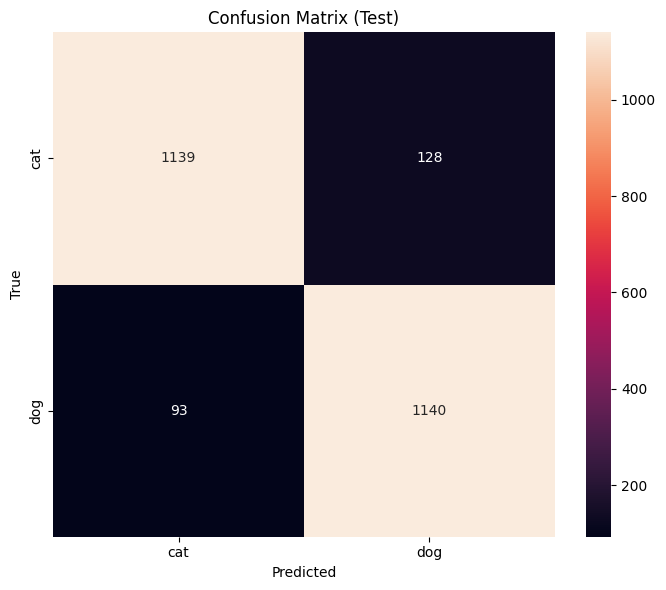

[eval] Classification report:

              precision    recall  f1-score   support

         cat     0.9245    0.8990    0.9116      1267
         dog     0.8991    0.9246    0.9116      1233

    accuracy                         0.9116      2500
   macro avg     0.9118    0.9118    0.9116      2500
weighted avg     0.9120    0.9116    0.9116      2500


[plot] Plotting training curves...



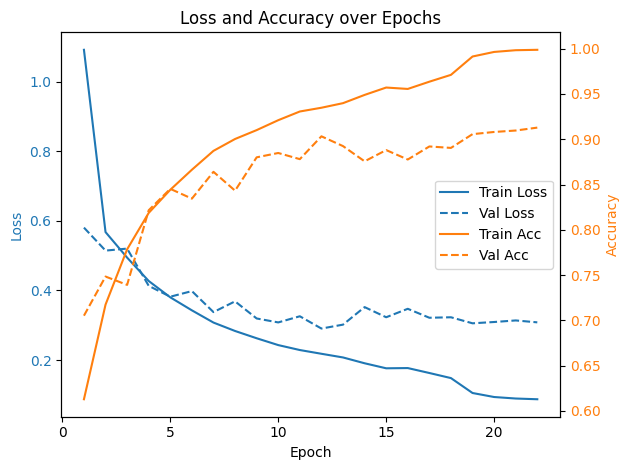

[done] Finished.



In [14]:
# ======================================================================
# Run the experiment on your folder dataset (Dogs vs Cats)
# ======================================================================
model = AlexNet(num_classes=2, p_drop=0.5)

results = run_imagefolder_experiment(
    data_dir="../data/dogs-vs-cats",
    model=model,
    img_size=224, resize_side=256, augment=True,
    splits=(0.8, 0.1, 0.1),
    batch_train=64, batch_eval=128,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4,
    epochs=1000, patience=10,             # early stopping patience
    monitor="acc", min_delta=0.0,
    lr_patience=5, lr_factor=0.1,         # ReduceLROnPlateau settings
    save_path="dogs_vs_cats_alexnet.pth",
)

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[data] Loading ImageFolder from: ../data/dogs-vs-cats
[data] Classes: ['cat', 'dog']
[data] label counts -> train: Counter({1: 10038, 0: 9962}) val: Counter({0: 1271, 1: 1229}) test: Counter({0: 1267, 1: 1233})

[data] Sizes -> train: 20000, val: 2500, test: 2500

[train] Setup complete. Starting training... Initial LR: 3.00e-04



[epoch 001 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 001 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 001] train: loss=1.9244, acc=0.5149 | val: loss=0.7893, acc=0.5348 | time: 98.71s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 002 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 002 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 002] train: loss=0.7800, acc=0.6081 | val: loss=0.6868, acc=0.6540 | time: 98.68s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 003 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 003 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 003] train: loss=0.6236, acc=0.7042 | val: loss=0.6400, acc=0.6460 | time: 97.99s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 004 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 004 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 004] train: loss=0.5187, acc=0.7654 | val: loss=0.5019, acc=0.7768 | time: 99.73s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 005 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 005 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 005] train: loss=0.4569, acc=0.8028 | val: loss=0.4842, acc=0.7764 | time: 99.78s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 006 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 006 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 006] train: loss=0.3872, acc=0.8425 | val: loss=0.4617, acc=0.8020 | time: 99.48s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 007 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 007 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 007] train: loss=0.3317, acc=0.8784 | val: loss=0.4095, acc=0.8328 | time: 97.37s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 008 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 008 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 008] train: loss=0.2850, acc=0.8995 | val: loss=0.3114, acc=0.9008 | time: 97.13s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 009 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 009 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 009] train: loss=0.2615, acc=0.9123 | val: loss=0.2912, acc=0.9264 | time: 98.15s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 010 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 010 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 010] train: loss=0.2283, acc=0.9290 | val: loss=0.2742, acc=0.9208 | time: 98.78s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 011 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 011 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 011] train: loss=0.2068, acc=0.9407 | val: loss=0.2827, acc=0.9264 | time: 99.22s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (2/10)


[epoch 012 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 012 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 012] train: loss=0.1940, acc=0.9470 | val: loss=0.2481, acc=0.9256 | time: 99.28s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (3/10)


[epoch 013 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 013 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 013] train: loss=0.1880, acc=0.9506 | val: loss=0.2994, acc=0.9228 | time: 99.50s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (4/10)


[epoch 014 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 014 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 014] train: loss=0.1744, acc=0.9578 | val: loss=0.2669, acc=0.9324 | time: 97.95s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 015 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 015 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 015] train: loss=0.1690, acc=0.9589 | val: loss=0.2595, acc=0.9244 | time: 97.09s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 016 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 016 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 016] train: loss=0.1572, acc=0.9645 | val: loss=0.2459, acc=0.9348 | time: 97.80s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 017 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 017 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 017] train: loss=0.1542, acc=0.9681 | val: loss=0.2494, acc=0.9388 | time: 99.40s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 018 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 018 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 018] train: loss=0.1437, acc=0.9710 | val: loss=0.2277, acc=0.9484 | time: 98.82s
  [lr] current learning rate: 3.00e-04
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 019 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 019 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 019] train: loss=0.1401, acc=0.9738 | val: loss=0.2612, acc=0.9292 | time: 98.75s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (1/10)


[epoch 020 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 020 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 020] train: loss=0.1346, acc=0.9764 | val: loss=0.2718, acc=0.9072 | time: 98.46s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (2/10)


[epoch 021 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 021 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 021] train: loss=0.1322, acc=0.9770 | val: loss=0.2274, acc=0.9436 | time: 98.81s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (3/10)


[epoch 022 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 022 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 022] train: loss=0.1317, acc=0.9784 | val: loss=0.2967, acc=0.9044 | time: 117.53s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (4/10)


[epoch 023 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 023 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 023] train: loss=0.1266, acc=0.9804 | val: loss=0.2036, acc=0.9472 | time: 97.87s
  [lr] current learning rate: 3.00e-04
  [early-stop] No improvement (5/10)


[epoch 024 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 024 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 024] train: loss=0.1197, acc=0.9833 | val: loss=0.2833, acc=0.8988 | time: 98.99s
Epoch 00024: reducing learning rate of group 0 to 3.0000e-05.
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (6/10)


[epoch 025 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 025 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 025] train: loss=0.0955, acc=0.9942 | val: loss=0.1852, acc=0.9564 | time: 104.23s
  [lr] current learning rate: 3.00e-05
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 026 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 026 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 026] train: loss=0.0872, acc=0.9979 | val: loss=0.1837, acc=0.9596 | time: 98.34s
  [lr] current learning rate: 3.00e-05
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 027 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 027 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 027] train: loss=0.0850, acc=0.9988 | val: loss=0.1896, acc=0.9572 | time: 97.70s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (1/10)


[epoch 028 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 028 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 028] train: loss=0.0842, acc=0.9988 | val: loss=0.1887, acc=0.9584 | time: 97.33s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (2/10)


[epoch 029 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 029 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 029] train: loss=0.0830, acc=0.9994 | val: loss=0.1952, acc=0.9572 | time: 97.73s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (3/10)


[epoch 030 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 030 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 030] train: loss=0.0825, acc=0.9993 | val: loss=0.1943, acc=0.9576 | time: 98.64s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (4/10)


[epoch 031 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 031 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 031] train: loss=0.0817, acc=0.9997 | val: loss=0.1957, acc=0.9600 | time: 98.91s
  [lr] current learning rate: 3.00e-05
  [checkpoint] New best model saved -> dogs_vs_cats_vgg_bn.pth


[epoch 032 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 032 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 032] train: loss=0.0813, acc=0.9997 | val: loss=0.1990, acc=0.9576 | time: 99.00s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (1/10)


[epoch 033 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 033 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 033] train: loss=0.0810, acc=0.9998 | val: loss=0.2090, acc=0.9548 | time: 118.21s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (2/10)


[epoch 034 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 034 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 034] train: loss=0.0811, acc=0.9997 | val: loss=0.2018, acc=0.9568 | time: 97.86s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (3/10)


[epoch 035 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 035 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 035] train: loss=0.0811, acc=0.9997 | val: loss=0.2037, acc=0.9572 | time: 97.23s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (4/10)


[epoch 036 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 036 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 036] train: loss=0.0811, acc=0.9994 | val: loss=0.2077, acc=0.9568 | time: 97.69s
  [lr] current learning rate: 3.00e-05
  [early-stop] No improvement (5/10)


[epoch 037 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 037 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 037] train: loss=0.0808, acc=0.9996 | val: loss=0.2080, acc=0.9552 | time: 98.61s
Epoch 00037: reducing learning rate of group 0 to 3.0000e-06.
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (6/10)


[epoch 038 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 038 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 038] train: loss=0.0802, acc=0.9999 | val: loss=0.2087, acc=0.9560 | time: 98.94s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (7/10)


[epoch 039 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 039 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 039] train: loss=0.0800, acc=0.9999 | val: loss=0.2076, acc=0.9564 | time: 99.13s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (8/10)


[epoch 040 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 040 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 040] train: loss=0.0799, acc=0.9999 | val: loss=0.2093, acc=0.9560 | time: 98.54s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (9/10)


[epoch 041 | train]:   0%|          | 0/313 [00:00<?, ?it/s]

[epoch 041 | val  ]:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch 041] train: loss=0.0800, acc=0.9998 | val: loss=0.2055, acc=0.9572 | time: 97.79s
  [lr] current learning rate: 3.00e-06
  [early-stop] No improvement (10/10)
  [early-stop] Patience exceeded — stopping.

[train] Total training time: 4110.52s

[eval] Evaluating on test set...


[test]:   0%|          | 0/20 [00:00<?, ?it/s]

[eval] Test accuracy: 0.9600



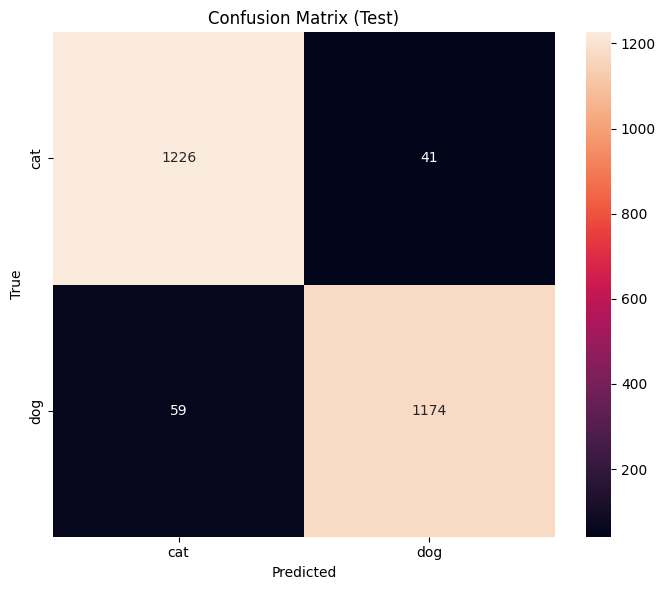

[eval] Classification report:

              precision    recall  f1-score   support

         cat     0.9541    0.9676    0.9608      1267
         dog     0.9663    0.9521    0.9592      1233

    accuracy                         0.9600      2500
   macro avg     0.9602    0.9599    0.9600      2500
weighted avg     0.9601    0.9600    0.9600      2500


[plot] Plotting training curves...



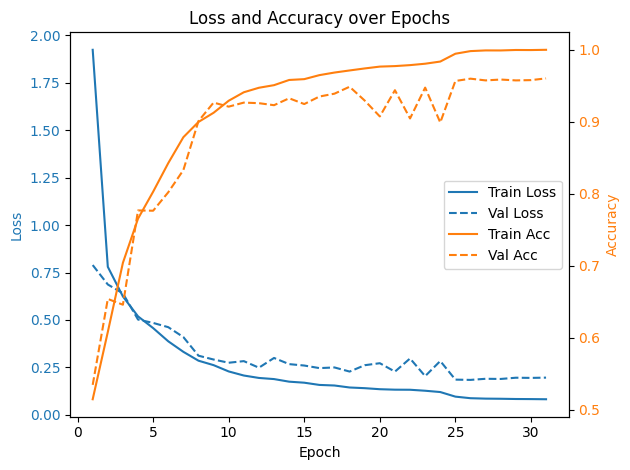

[done] Finished.



In [7]:
# ======================================================================
# Run VGG on your ImageFolder dataset (Dogs vs Cats)
# ======================================================================
model = VGGNet(num_classes=2, p_drop=0.5)

results = run_imagefolder_experiment(
    data_dir="../data/dogs-vs-cats",
    model=model,
    img_size=224, resize_side=256, augment=True,
    splits=(0.8, 0.1, 0.1),
    batch_train=64, batch_eval=128,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4,
    epochs=1000, patience=10,             # early stopping
    monitor="acc", min_delta=0.0,
    lr_patience=5, lr_factor=0.1,       # ReduceLROnPlateau
    save_path="dogs_vs_cats_vgg_bn.pth",
)